Dataset loaded successfully!
   Longitude   Latitude  Speed  Distance                 Time     Acc X  \
0  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12  0.046402   
1  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12 -0.136978   
2  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.045355   
3  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13  0.242089   
4  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.230234   

      Acc Y     Acc Z  Heading    gyro_x  ...  Gyro_Change  Net_Displacement  \
0 -0.137178 -0.282934      352 -0.036306  ...     0.000000               0.0   
1  0.365242  0.108889      352  0.035776  ...    -0.005758               0.0   
2 -0.103340 -0.534985      352 -0.011871  ...    -0.007818               0.0   
3  0.072761 -0.350396      352 -0.017980  ...    -0.011512               0.0   
4  0.011765 -0.494085      352  0.011342  ...    -0.005381               0.0   

   Speed_Change  Heading_Change  Rollin

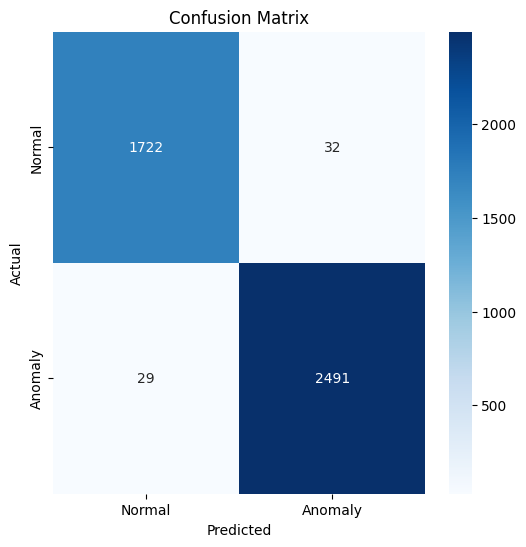

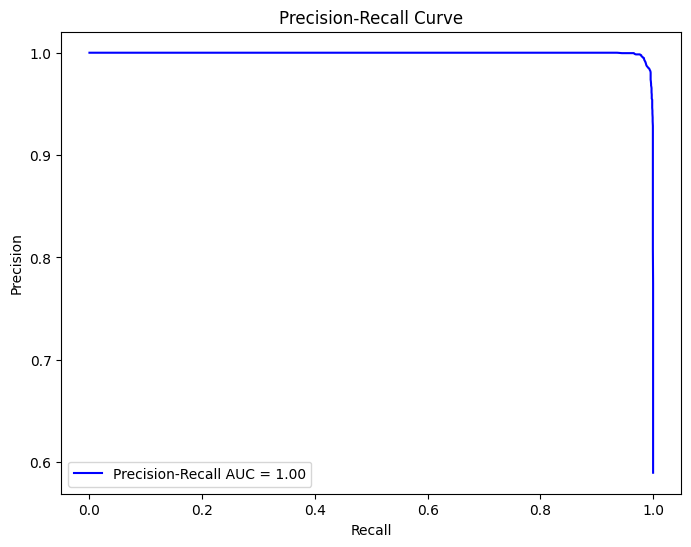

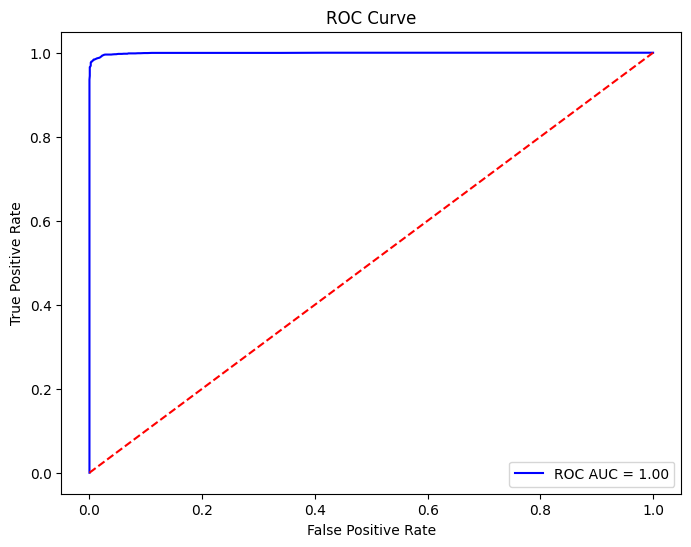

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_l

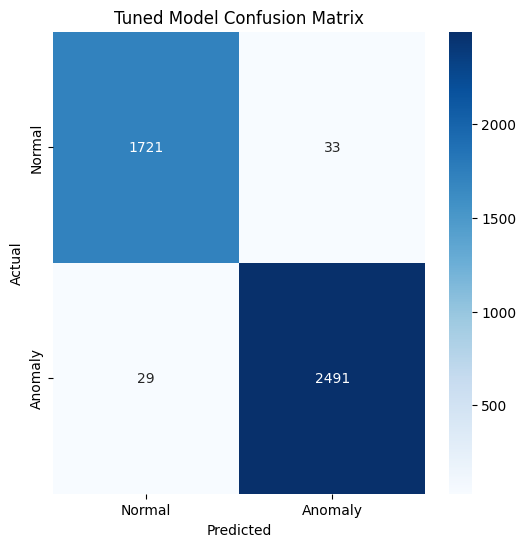

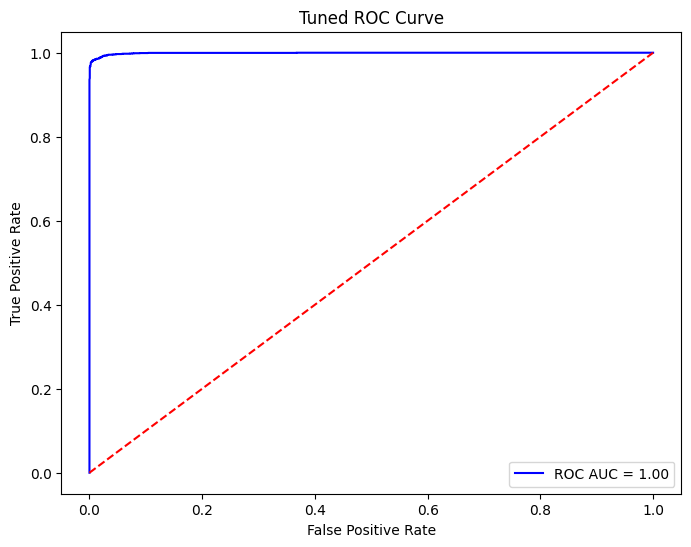

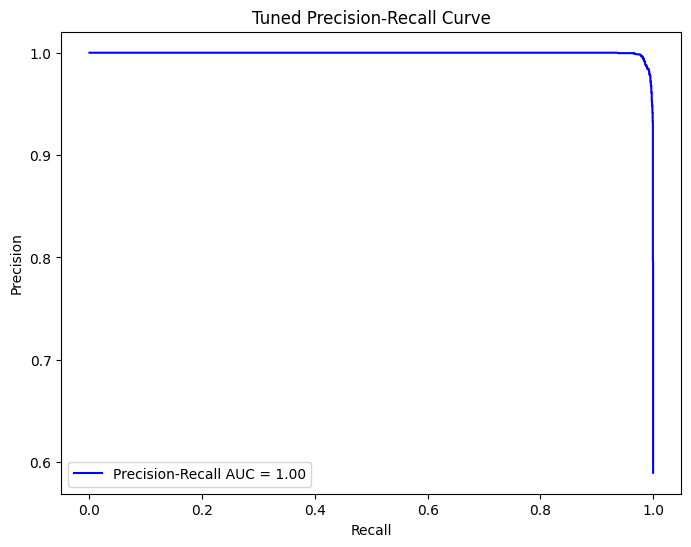

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from joblib import parallel_backend  # For controlling parallelism

# Step 1: Load your dataset
file_path = 'Featured_dataset.csv'  # Specify your full file path here

try:
    # Load dataset
    data = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print(data.head())
    
except FileNotFoundError:
    print(f"File '{file_path}' not found. Please check the file path.")
    exit()  # Exit the script if the file is not found

# Step 2: Data Preprocessing
# Check the column names and inspect the data types
print("\nColumn Names in the Dataset:\n", data.columns)

# Convert non-numeric columns (e.g., timestamps or categorical data) to numeric values
# Example: Convert timestamps to numerical representation (e.g., seconds since a reference date)

# If 'timestamp' column exists, process it
if 'timestamp' in data.columns:
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['timestamp'] = (data['timestamp'] - data['timestamp'].min()).dt.total_seconds()
else:
    print("Warning: No 'timestamp' column found. Skipping timestamp processing.")

# Handle categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# For simplicity, let's encode categorical columns to numeric using LabelEncoder
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Separate features and target label
X = data.drop(columns=['label'])  # Features (all columns except 'label')
y = data['label']  # Labels (0 - normal, 1 - anomaly)

# Scale features (important for models like IsolationForest or tree-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Handle Class Imbalance (if applicable)
# Compute class weights for balancing the data during training
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Step 5: Model Training using RandomForestClassifier (can also be Isolation Forest or One-Class SVM)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class (anomalous)

# Classification report (Precision, Recall, F1 Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Step 7: Model Tuning with GridSearchCV (optional, improves model performance)
# Reduce grid search space to minimize memory consumption
param_grid = {
    'n_estimators': [50, 100],  # Limit the number of trees
    'max_depth': [10, 20],       # Limit depth of the trees
    'min_samples_split': [2, 5], # Limit number of samples to split nodes
    'min_samples_leaf': [1, 2]   # Limit number of samples per leaf
}

# Perform GridSearchCV with limited parallelism to avoid memory errors
with parallel_backend('threading'):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)

# Get best parameters and best model
best_model = grid_search.best_estimator_
print(f"Best model parameters: {grid_search.best_params_}")

# Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

print("Tuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

# Confusion Matrix for tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title("Tuned Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and Precision-Recall curves for tuned model
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label=f'ROC AUC = {roc_auc_tuned:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve for tuned model
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_pred_proba_tuned)
pr_auc_tuned = auc(recall_tuned, precision_tuned)

plt.figure(figsize=(8, 6))
plt.plot(recall_tuned, precision_tuned, color='blue', label=f'Precision-Recall AUC = {pr_auc_tuned:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned Precision-Recall Curve')
plt.legend()
plt.show()
